## Convolution based on... (DIMENSION TO DO CONVOLUTION ON) 
- Gene functionality (GO analysis) 
- Each convolutional layer is the top k genes correlated with the target genes (i.e. n_top = 5) 
- Random 

## Thungs to try instead of correlation
- Euclidean distance in n-dim array 
- Manhattan distance (look into it?) 
- Root Mean Squared Error 

## Activation functions to test (if I understand this correctly)
- ReLU (default) 
- Sigmoid (all positive, "gradual") 
- Softplus (gradual ReLU) 

## Loss function...
"The loss function to use during training is typically the mean squared error, but if you have a lot of outliers <br />
in the training set, you may prefer to use the mean absolute error instead. Alternatively, you can use the Huber <br />
loss, which is a combination of both."

## Dropout layer 
- "...closer to 20–30% in recurrent neural nets, and closer to 40–50% in convolutional neural networks."

In [1]:
import tensorflow as tf
import scanpy as sc
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.optimizers import Adam
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping
import keras.losses
from keras import backend as K
from scipy.stats import pearsonr

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Preparation

In [2]:
adata = sc.read_10x_mtx(
    '/Volumes/Samsung_T5/ResearchData/scanpyTutorial/data/filtered_gene_bc_matrices/hg19',  # the directory with the `.mtx` file
    var_names='gene_symbols',                      # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata.var_names_make_unique()

In [3]:
data = pd.DataFrame.sparse.from_spmatrix(adata.X)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 2700 cells and 32738 genes


In [4]:
VMR = data.std() / data.mean()  # coefficient of variation: stdDev/mean (relative magnitude of std dev)
VMR[np.isinf(VMR)] = 0  # if mean is 0, we would get an infinite value --> set it to zero
potential_pred = data.columns[VMR > 0]

In [5]:
# Create covariance matrix (pd data frame),
covariance_matrix = pd.DataFrame(np.abs(np.corrcoef(data[potential_pred], rowvar= False)), # rowvar=False -> each column represents variable
    index=potential_pred,
    columns=potential_pred).fillna(0) # setting column names and fill NA with 0

covariance_matrix.shape; max(pd.Series.max(covariance_matrix)); min(pd.Series.min(covariance_matrix))


(16634, 16634)

1.0

0.0

In [7]:
# data_pred_unnorm = data.loc[:,potential_pred] # UNNORMALIZED

# gene_metric = (data_pred_unnorm.var()/(1+data_pred_unnorm.mean())).sort_values(ascending=False)
# gene_metric = gene_metric[gene_metric > 0]

# data_pred = np.log1p(data_pred_unnorm).astype(np.float32)

In [24]:
data_pred_full = data.loc[:,potential_pred] # UNNORMALIZED

gene_metric = (data_pred_full.var()/(1+data_pred_full.mean())).sort_values(ascending=False)
gene_metric = gene_metric[gene_metric > 0]

data_pred_full.shape

(2700, 16634)

In [27]:
# separating 10% that will be untouched during cross-validation
untouched_10_index = np.random.choice(data_pred_full.index, int(0.10 * data_pred_full.shape[0]), replace=False)
untouched_10 = data_pred_full.loc[untouched_10_index,:]
untouched_10.shape

touched_90_index = np.setdiff1d(data_pred_full.index, untouched_10_index)
data_pred = data_pred_full.loc[touched_90_index,:]
data_pred.shape

(270, 16634)

(2430, 16634)

In [28]:
# Defining target variable (y = 512 genes, x = 1800 ish genes)
batch = 1
indx = range((512*(batch-1)),(512*batch))
print('Working on Batch {}'.format(batch))

target_index = gene_metric.index[indx]
target = data_pred.loc[:,target_index]
target.shape

not_target_index = gene_metric.index[list(set(range(16634)) - set(indx))]
not_target = data_pred.loc[:,not_target_index]
not_target.shape

Working on Batch 1


(2430, 512)

(2430, 16122)

In [29]:
subMatrix = covariance_matrix.loc[target_index, not_target_index]
subMatrix.shape; max(pd.Series.max(subMatrix)); min(pd.Series.min(subMatrix))

(512, 16122)

0.9896605340015643

0.0

In [30]:
x = []
for i in range(512):
    indx = pd.Series.nlargest(subMatrix.iloc[i,:], 5).index
    x.extend(pd.Index.tolist(indx))
predictor_index = set(x) #keep unique only
predictor = data_pred.loc[:,predictor_index]
predictor.shape

(2430, 1425)

# Trying Cross Validation 

In [31]:
# Normal way
X_train, X_test, y_train, y_test = train_test_split(np.asarray(predictor), np.asarray(target), test_size=0.05)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2308, 1425) (2308, 512)
(122, 1425) (122, 512)


In [32]:
model = Sequential([ 
    Input(shape=( predictor.shape[1] ,)), 
    Dense(units=256, activation="relu"), 
    Dropout(rate=0.2),
    Dense(units=512, activation="softplus")
])

model.summary()
model.layers[0].get_weights()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               365056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
Total params: 496,640
Trainable params: 496,640
Non-trainable params: 0
_________________________________________________________________


[array([[-0.04244902, -0.05158878, -0.02538938, ...,  0.05638805,
         -0.0009089 , -0.0028037 ],
        [-0.03996004, -0.02327196,  0.00896781, ...,  0.03340445,
          0.05302871,  0.03131932],
        [ 0.04178888,  0.05362334,  0.05917939, ..., -0.01493469,
          0.02819781,  0.00310026],
        ...,
        [ 0.03894501, -0.00390575,  0.0210615 , ...,  0.03662151,
         -0.04158338, -0.02303334],
        [ 0.01950132, -0.04641075, -0.0145807 , ..., -0.00769969,
          0.00153995,  0.04622838],
        [ 0.05273062,  0.0249234 ,  0.01818494, ...,  0.01158524,
          0.01059407, -0.02490923]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [397]:
def wMSE(y_true, y_pred, binary=False):
    if binary:
        weights = tf.cast(y_true>0, tf.float32)
    else:
        weights = y_true
    return tf.reduce_mean(weights*tf.square(y_true-y_pred)) 

model.compile(optimizer=Adam(lr=0.0001), loss=wMSE, metrics=["accuracy"]) # using same optimizer and loss function as DeepImpute 

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=500, batch_size=64)
#                    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1)

Epoch 1/500
41/41 [==============================] - 5s 133ms/step - loss: 1.8769 - accuracy: 0.0203 - val_loss: 1.7297 - val_accuracy: 0.0444
Epoch 2/500
41/41 [==============================] - 0s 4ms/step - loss: 1.2986 - accuracy: 0.0694 - val_loss: 0.8658 - val_accuracy: 0.1185
Epoch 3/500
41/41 [==============================] - 0s 4ms/step - loss: 0.6324 - accuracy: 0.1057 - val_loss: 0.4995 - val_accuracy: 0.1259
Epoch 4/500
41/41 [==============================] - 0s 4ms/step - loss: 0.4631 - accuracy: 0.1887 - val_loss: 0.4305 - val_accuracy: 0.2815
Epoch 5/500
41/41 [==============================] - 0s 4ms/step - loss: 0.4113 - accuracy: 0.2694 - val_loss: 0.3915 - val_accuracy: 0.3630
Epoch 6/500
41/41 [==============================] - 0s 4ms/step - loss: 0.3823 - accuracy: 0.2986 - val_loss: 0.3625 - val_accuracy: 0.4148
Epoch 7/500
41/41 [==============================] - 0s 4ms/step - loss: 0.3575 - accuracy: 0.3201 - val_loss: 0.3405 - val_accuracy: 0.4519
Epoch 8/500

(0.0, 1.0)

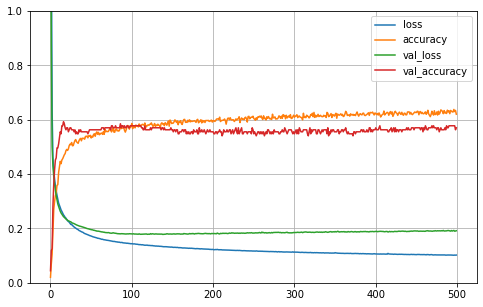

In [400]:
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

In [405]:
Y_test_raw = np.hstack(y_test).flatten()
Y_test_imputed = np.hstack(model.predict(X_test)).flatten()

Y_test_imputed = Y_test_imputed[Y_test_raw>0]
Y_test_raw = Y_test_raw[Y_test_raw>0]

pearsonr(Y_test_raw,Y_test_imputed)[0],

(0.8576766456717055,)

# Trying Methods Besides Deep Neural Networks
- Random Forrest?
- Classification Trees?
- Regression?

In [522]:
gene_30933_100_index = pd.Series.nlargest(subMatrix.iloc[0,:], 100).index
gene_30933_100_index = gene_30933_100_index.insert(loc=0, item=30933)  #Adding "y"

gene_30933_100 = data_pred_unnorm.loc[:,gene_30933_100_index]

In [523]:
gene_30933_100.index = list(range(1,2701))
gene_30933_100.rename(columns={30933: 'y30933'}, inplace = True)
gene_30933_100

,y30933,26286,12570,29701,28881,29176,31196,22493,29827,12627,...,7341,29988,11858,7188,15913,22465,20008,31213,23405,764
1,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,78.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2696,88.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2697,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
2698,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2699,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [524]:
gene_30933_100.to_csv("/Users/ahmadazim/Documents/Research/imputeML/gene_30933_100.csv", index=True)

In [525]:
target.describe()

,30933,18998,21053,1955,9798,10677,11887,13302,1957,28817,...,17597,113,12646,22162,4130,439,11940,30114,3517,29538
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,2.457839,2.349489,1.127563,0.738349,1.500419,1.057086,2.561134,3.672724,0.540868,0.777489,...,0.307567,0.175108,0.212813,0.063072,0.458054,0.133351,0.079387,0.164015,0.169051,0.206075
std,1.260208,1.134424,1.398795,1.256057,1.152750,1.226931,0.837687,0.603685,1.042676,1.168722,...,0.434491,0.344565,0.380495,0.226848,0.519108,0.350104,0.247311,0.405440,0.339583,0.371577
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.609438,1.609438,0.000000,0.000000,0.693147,0.000000,2.079442,3.332205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.079442,2.079442,0.693147,0.000000,1.098612,0.693147,2.564949,3.688879,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.441924,2.995732,1.386294,0.693147,2.397895,2.079442,3.091043,4.043051,0.693147,1.098612,...,0.693147,0.000000,0.693147,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147
max,5.971262,6.040255,5.257495,5.135798,5.455321,5.476463,5.736572,5.953243,4.442651,4.836282,...,3.970292,3.850147,3.737670,3.988984,3.258096,3.891820,3.970292,3.610918,3.871201,3.688879


In [526]:
predictor.describe()

,24577,24592,16401,8224,36,16421,40,16433,16439,8248,...,16314,24527,32722,16342,16343,8157,16351,8164,8165,16361
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.078019,0.000257,0.029228,0.000257,0.002310,0.000257,0.046294,0.000257,0.000513,0.000407,...,0.000257,0.036518,0.000513,0.000513,0.000513,0.000513,0.001027,0.000257,0.000257,0.103054
std,0.241816,0.013340,0.154096,0.013340,0.039960,0.013340,0.204300,0.013340,0.018862,0.021143,...,0.013340,0.159245,0.018862,0.018862,0.018862,0.018862,0.026664,0.013340,0.013340,0.296921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.332205,0.693147,3.295837,0.693147,0.693147,0.693147,1.791759,0.693147,0.693147,1.098612,...,0.693147,1.609438,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,2.079442
